# Pâmella job robot seeker

#### Imports libs

In [1]:
import os
import pandas as pd
import numpy
import json
import re

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC

import seaborn as sn
import matplotlib.pyplot as plt

%matplotlib inline

/home/rodrigo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Read dataset

In [2]:
data = pd.read_csv('job-robot_2018_11_11__13_00_57.csv', header=None)

#### Remove special characters from data

In [3]:
data[1] = data[1].fillna('')
data[1] = data[1].map(lambda x: x.replace("–", " "))

data[5] = data[5].fillna('')
data[5] = data[5].map(lambda x: x.replace(r"\N", " "))
data[5] = data[5].map(lambda x: re.sub(r'\W+', ' ', x))
data[5] = data[5].map(lambda x: x.replace("–", " "))
data[5] = data[5].map(lambda x: x.replace("•", " "))
data[5] = data[5].map(lambda x: x.replace("\\", " "))
data[5] = data[5].map(lambda x: x.replace("/", " "))
data[5] = data[5].map(str.strip)

data[6] = data[6].fillna('')
data[6] = data[6].map(lambda x: x.replace(r"\N", " "))
data[6] = data[6].map(lambda x: re.sub(r'\W+', ' ', x))
data[6] = data[6].map(lambda x: x.replace("–", " "))
data[6] = data[6].map(lambda x: x.replace("•", " "))
data[6] = data[6].map(lambda x: x.replace("\\", " "))
data[6] = data[6].map(lambda x: x.replace("/", " "))
data[6] = data[6].map(str.strip)

### Target analysis

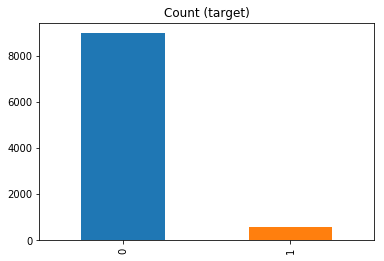

In [4]:
target_count = data[15].value_counts()
target_count.plot(kind='bar', title='Count (target)', label=True);

As seen, the classes are not balanced. 

#### Oversampling positive data

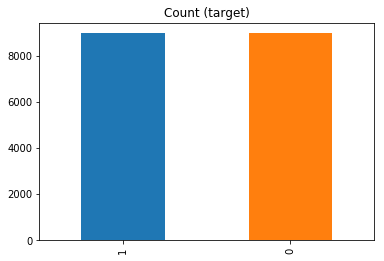

In [7]:
count_class_0, count_class_1 = data[15].value_counts()

df_applied = data[data[15] == 1]
df_not_applied = data[data[15] == 0]

df_applied = df_applied.sample(count_class_0, replace=True)
df_over = pd.concat([df_not_applied, df_applied], axis=0)

df_over[15].value_counts().plot(kind='bar', title='Count (target)');

### Training preprocess

#### Removing stop words

In [8]:
with open('stopwords.json') as f:
    stopWords = json.loads(f.read())

df_over[1] = df_over[1].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stopWords)]))
df_over[5] = df_over[5].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stopWords)]))
df_over[6] = df_over[6].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stopWords)]))
df_over[16] = df_over.apply(lambda row: " ".join([row[1], row[5], row[6]]), axis=1)

#### Vectorize the texts

In [9]:
vectorizer = CountVectorizer()
vectorizer.fit(df_over[16])

x = [0] * len(df_over[16])

for i in range(len(df_over[16])):
    x[i] = vectorizer.transform([df_over[16].values[i]]).toarray()
    
x = numpy.squeeze(x)
y = df_over[15]

#### Split data into train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)

## Logistic Regression

In [11]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Predict test data

In [12]:
y_pred = logreg.predict(X_test)
logreg.score(X_test, y_test)

0.9627730717788676

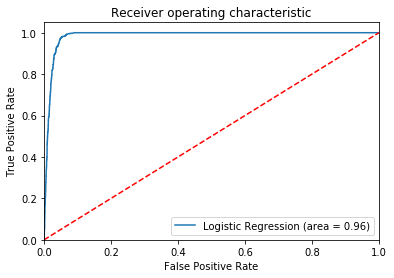

In [13]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.93      0.96      4449
          1       0.94      0.99      0.96      4523

avg / total       0.96      0.96      0.96      8972



/home/rodrigo/anaconda3/lib/python3.6/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


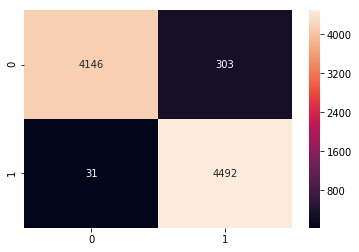

In [15]:
sn.heatmap(confusion_matrix(y_test.values.tolist(), y_pred.tolist()), annot=True, fmt="d")

In [19]:
logreg.predict([X_test[1]])

array([1])